In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dly files can be downloaded from https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/all/

In [2]:
def compute_mean(dfs, elem_name, last_year=2022, year_window=[5,30]):
    recent, history = [], []
    for df in dfs:
        if elem_name in df:
            tmp = df.groupby('year').agg(np.nanmean)[elem_name]
            year = tmp.index.to_numpy()
            elem = tmp.to_numpy()
            idx = (year>last_year-year_window[0]) & (year<=last_year)
            jdx = (year>last_year-np.sum(year_window)) & (year<=last_year-year_window[0])
            if any(idx) and any(jdx):
                recent.append(elem[idx].mean())
                history.append(elem[jdx].mean())
    return np.array(recent), np.array(history)

In [3]:
country_code = 'SWE'
data_dir = 'ghcnd_' + country_code
data_files = sorted(glob.glob(os.path.join(data_dir, '*.gz')))
stations = [os.path.basename(f).split('.')[0] for f in data_files]
dfs = [pd.read_parquet(f) for f in data_files]

In [4]:
last_year = 2022
window = [5, 30]
recent, history = {}, {}
for elem_name in ('tmax', 'tmin'):
    recent[elem_name], history[elem_name] = compute_mean(dfs, elem_name, last_year, window)

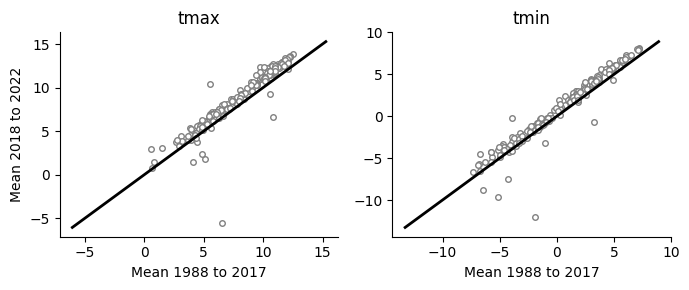

In [5]:
fig,ax = plt.subplots(1, 2, figsize=(7,3))
for i,key in enumerate(recent):
    ax[i].plot(history[key], recent[key], 'o', color=[.5,.5,.5], markersize=4,
               markerfacecolor='w', markeredgewidth=1)
    m = min(np.nanmin(history[key]), np.nanmin(recent[key]))
    M = max(np.nanmax(history[key]), np.nanmax(recent[key]))
    m = m * 0.9 if m > 0 else m * 1.1
    M = M * 1.1 if M > 0 else M * 0.9
    ax[i].plot([m,M], [m,M], 'k', lw=2)
    ax[i].set_title(key)
    ax[i].set_xlabel('Mean {} to {}'.format(last_year-np.sum(window)+1, last_year-window[0]))
ax[0].set_ylabel('Mean {} to {}'.format(last_year-window[0]+1, last_year))
sns.despine()
fig.tight_layout()

In [6]:
delta_T = (recent['tmax'] - history['tmax'])
delta_T = delta_T[np.logical_not(np.isnan(delta_T))]
de = 0.2
edges = np.r_[-2 : 5 : de]
n,_ = np.histogram(delta_T, edges)

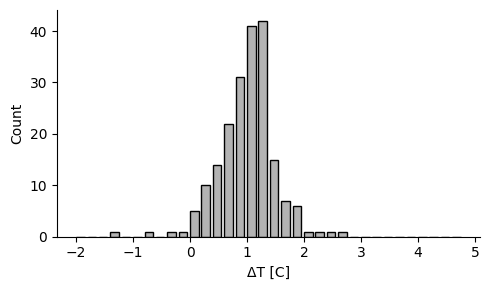

In [7]:
fig,ax = plt.subplots(1, 1, figsize=(5,3))
ax.bar(edges[:-1], n, width=de*0.75, align='edge', facecolor=.7+np.zeros(3), edgecolor='k', linewidth=1)
ax.set_xlabel('ΔT [C]')
ax.set_ylabel('Count')
sns.despine()
fig.tight_layout()